# Лабораторная работа №3. Синтез БИХ-фильтров




## Модуль 1. Метод размещения нулей и полюсов.


### Задача 1.1 Синтез цифрового резонатора

| Варианты: |   $1$ |    $2$ |    $3$ |    $4$ |    $5$ |    $6$ |     $7$ |    $8$ |    $9$ |    $10$ | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $\nu_0$  | $0.25$ | $0.2$ | $0.1$ |  $—$ | $—$ | $—$ | $0.3$ | $0.15$ | $0.35$ | $0.4$ |
|$\theta_0$ | $—$ | $—$ | $—$ | $\dfrac\pi6$ | $\dfrac\pi3$ | $\dfrac\pi2$ |  $—$ | $—$ | $—$ | $—$ |

Синтезировать методом размещения нулей и полюсов цифровой резонатор для частоты $\nu_0$ или $\theta_0$ (в зависимости от варианта). Параметр, влияющий на добротность резонатора, подобрать самостоятельно.

* Построить нуль-полюсную диаграмму получившегося фильтра.
* Записать передаточную функцию $H(z)$.
* Вычислить аналитически импульсную и переходную характеристики и сравнить с результатами моделирования.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.

In [946]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile as wav
from IPython.display import Audio

In [947]:
Q0 = np.pi/3
v0 = Q0/(2*np.pi)

In [948]:
# Python класс для анализа фильтра
class Filter():
    def __init__(self, dlti_args, fs=1.0):
#         Инициализация на основе объекта signal.dlti
        self.fs = fs
        self.system_dlti=signal.dlti(*dlti_args, dt=1.0/fs)
        self.alpha_beta()
        self.zpk()
    def alpha_beta(self):
#         Вычисление коэффициентов alpha beta
        system = signal.TransferFunction(self.system_dlti)
        self.beta = system.num
        self.alpha = system.den
    def zpk(self):
#         Вычисление нулей, полюсов и множителя        
        system = self.system_dlti.to_zpk()
        self.zeros = system.zeros
        self.poles = system.poles
        self.gain = system.gain
    def zpk_plot(self):
#         Нуль-полюсная диаграмма
        plt.figure()
        q = np.linspace(0, 2*np.pi, 401)
        ax = plt.axes()
        ax.set_aspect(aspect='equal', adjustable='datalim')
        plt.plot(np.cos(q), np.sin(q), 'k--')  
        plt.plot(self.zeros.real, self.zeros.imag, 'ro', label='Нули')
        plt.plot(self.poles.real, self.poles.imag, 'bx', label='Полюса')
        plt.grid()
        plt.legend() #bbox_to_anchor=(1.05, 1), loc=2, numpoints=1
        plt.title("Нуль-полюсная диаграмма")
        plt.xlabel("Re $z$")
        plt.ylabel("Im $z$")
        plt.tight_layout()
        plt.show()
    def H(self, z):
#         Вычисление функции H(z) для заданного z. Требует предварительного вычисления нулей и полюсов.
        H = self.gain+0
        for z1 in self.zeros:
            H *= (z-z1)
        for p1 in self.poles:
            H /= (z-p1)
        return H
    
    def abs_H_plot(self):
#         Трехмерный график |H(z)|
        fig = plt.figure(dpi=160)
        ax = plt.axes(projection='3d')
        Re=np.arange(-1.2, 1.2, 0.1)
        Im=np.arange(-1.2, 1.2, 0.1)
        Re, Im = np.meshgrid(Re, Im)
        Z1=(Re+1j*Im)
        
        
        Z=abs(self.H(Z1))
        Z=np.minimum(Z, 40*np.ones(Z.shape))


        phi=np.linspace(0, 2*np.pi, 500)
        #ax.plot_surface(Re, Im, Z, linewidth=0, antialiased=True, color='silver')
        ax.plot_wireframe(Re, Im, Z, color='silver')

        for u in phi:
            Z1=np.exp(-1j*u)
            Z2=abs(self.H(Z1))
            ax.plot([Z1.real, Z1.real], [Z1.imag, Z1.imag], [0.0, Z2],  color=(abs(np.cos(u)), 0.7, 0.5))


        Z1=np.exp(-1j*phi)
        Z2=abs(self.H(Z1))

        ax.plot(Z1.real, Z1.imag, Z2, linewidth=2, color='b')

        ax.set_zlim(0, 1.2*max(Z2))
        ax.set_xticks(np.linspace(-1, 1, 5))
        ax.set_yticks(np.linspace(-1, 1, 5))
        ax.set_zticks(np.linspace(0, max(Z2), 5))
        ax.view_init(40, 240)
        ax.set_xlabel("Re $z$")
        ax.set_ylabel("Im $z$")

        ax.zaxis.set_rotate_label(False)  # disable automatic rotation
        ax.set_zlabel("$|H(z)|$", rotation=0)
        plt.tight_layout()
    def lfilter_resp(self, x):
#         Фильтрация заданного сигнала
        return signal.lfilter(self.beta, self.alpha, x)
    def lfilt_plot(self, x, label='y'):
        self.alpha_beta()
#         График сигнала на выходе фильтра при заданном входе
        y = self.lfilter_resp(x)
        plt.figure(figsize=[8, 3])
        plt.title("Сигнал на выходе фильтра")
        plt.stem(np.arange(y.shape[0]), y)
        plt.xlabel("$k$")
        plt.ylabel("$%s[k]$" %label)
        plt.tight_layout()
        plt.grid()
    def step_resp_plot(self, n=20):
        t, y = signal.dstep(self.system_dlti, n=n)
        plt.figure(figsize=[8, 3])
        plt.title("Переходная характеристика")
        y=np.squeeze(y)
        plt.stem(np.arange(len(y)), y)
        plt.xlabel("$k$")
        plt.ylabel("$g[k]$")
        plt.tight_layout()
        plt.grid()
    def impulse_resp_plot(self, n=20):
        t, y = signal.dimpulse(self.system_dlti, n=n)
        plt.figure(figsize=[8, 3])
        plt.title("Импульсная характеристика")
        y=np.squeeze(y)
        plt.stem(np.arange(len(y)), y)
        plt.xlabel("$k$")
        plt.ylabel("$h[k]$")
        plt.tight_layout()
        plt.grid()
    def freqresp_plot(self, f_scale='f', whole=True):
#         АЧХ фильтра
        w, H = self.system_dlti.freqresp(w=None, n=2**18, whole=whole)
        if whole:
            w, H = w-np.pi, np.fft.fftshift(H)
        figure1 = plt.figure(figsize=[8, 6])
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)
        
        
        
        for ax in [ax1, ax2]:
            if f_scale=='f':
                f = self.fs*(w/(2*np.pi))/1e3
                ax.set_xlabel("$f$, кГц")    
            elif f_scale=='\\nu':
                f = w/(2*np.pi)
                ax.set_xlabel("$%s$" % f_scale)
            elif f_scale=='\\theta':
                f = w
                ax.set_xlabel("$%s$, рад" % f_scale) 
            ax.set_xlim([f[0], f[-1]])
            ax.grid()
            
        ax1.set_title("AЧХ фильтра")    
        ax1.plot(f, abs(H))
        ax1.set_ylabel("$|H(%s)|$" % f_scale)
        
        
        ax2.plot(f, np.angle(H))
        ax2.set_ylabel("$\\varphi(%s)$" % f_scale)
        ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=("$-\\pi$", "$-\\pi/2$", "$0$", "$\\pi/2$", "$\\pi$"))
        plt.tight_layout()
        

In [949]:
f1=Filter(dlti_args=([np.exp(2j*np.pi*v0), np.exp(-2j*np.pi*v0)], [-0.5, 0.5], 1), fs=1e3)

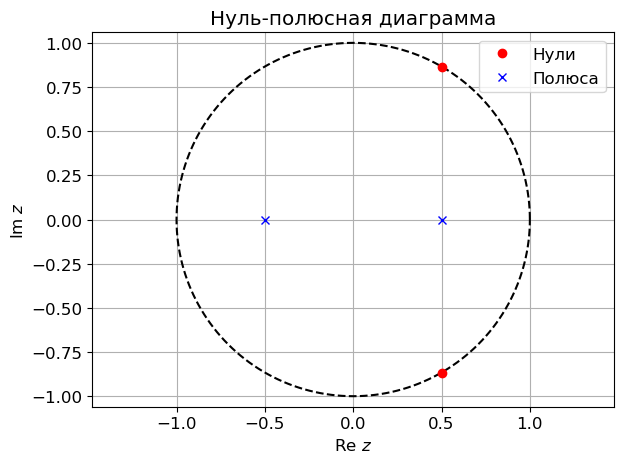

In [950]:
f1.zpk_plot()

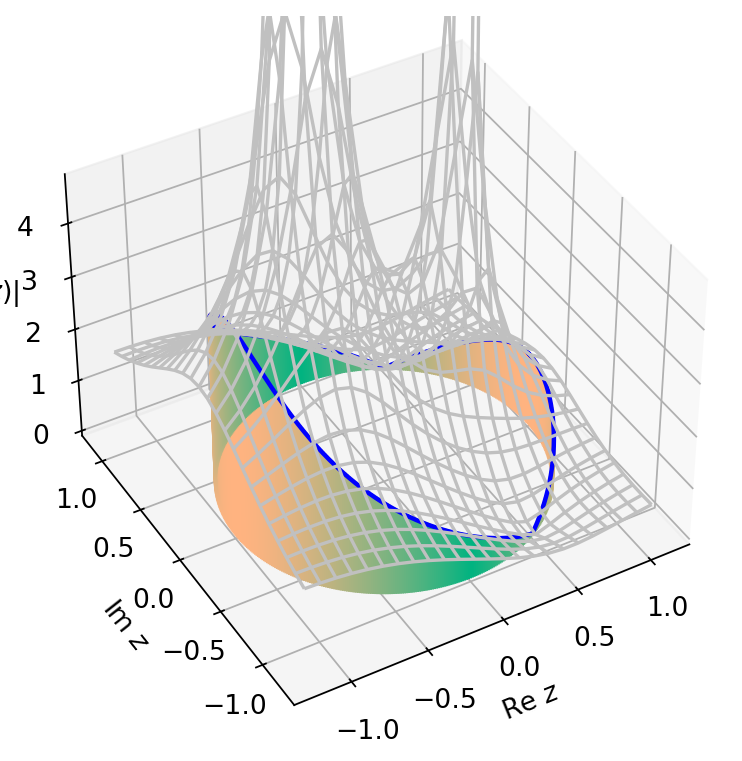

In [951]:
f1.abs_H_plot()

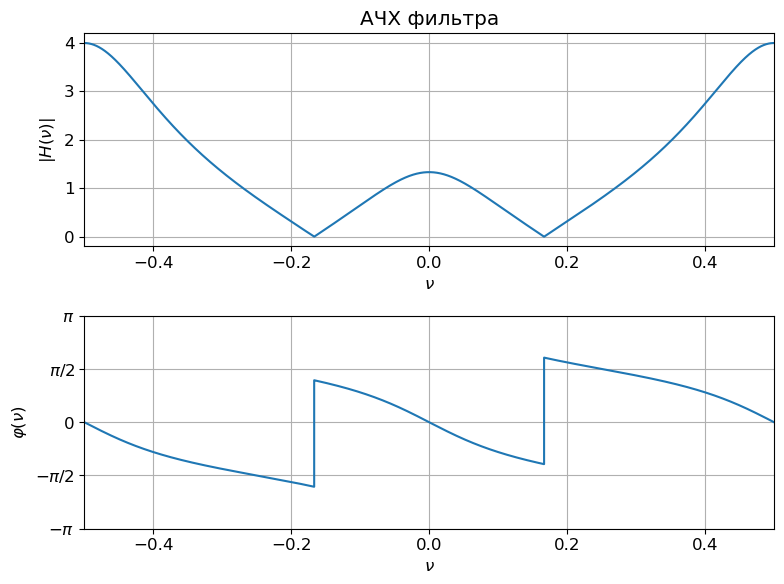

In [952]:
f1.freqresp_plot(f_scale='\\nu')

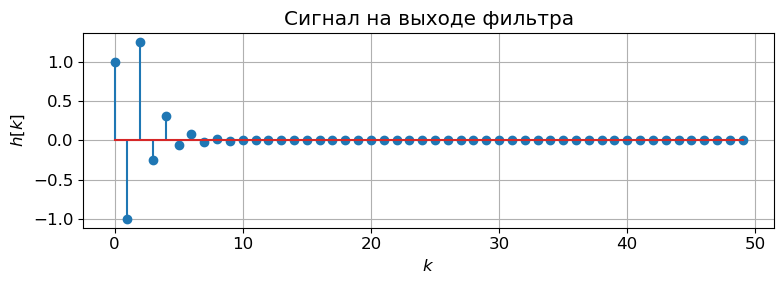

In [953]:
f1.lfilt_plot(signal.unit_impulse(50),label='h')

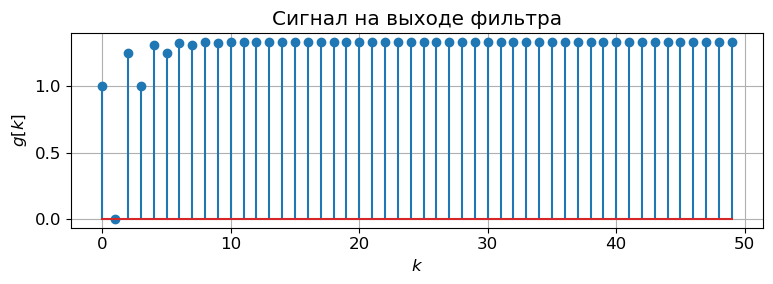

In [954]:
f1.lfilt_plot(np.ones(50),label='g')

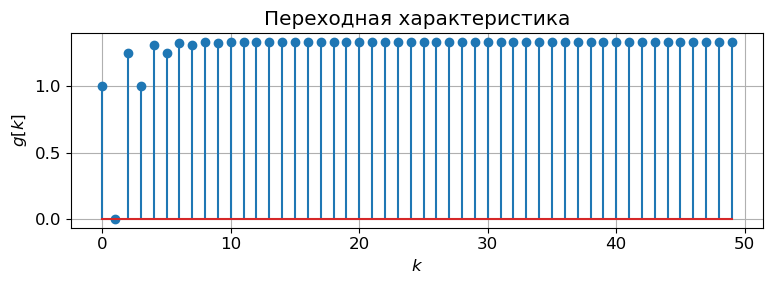

In [955]:
f1.step_resp_plot(n=50)

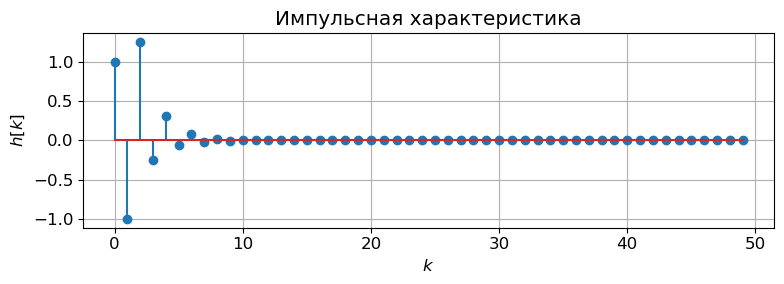

In [956]:
f1.impulse_resp_plot(n=50)

### Задача 1.2 Синтез цифрового фильтра Hum removal

| Варианты: |   1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |  
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $f_0$, Гц  | 250 | 350 | 400 |  200 | 100 | 150 | 250 | 500| 600 | 350 |
|  $f_д$, Гц | 1000 | 1000 | 1000 | 500 | 500 | 500 | 1000 | 2000 | 2000 | 2000 |

Синтезировать методом размещения нулей и полюсов цифровой фильтр Hum removal  для частоты $f_{0}$, $f_{д}$. Параметр, влияющий на добротность, подобрать самостоятельно.

* Записать передаточную функцию $H(z)$.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.


In [957]:
f0 = 150 #frequency, that should be removed from signal
fd = 500
Q = 30.0
beta, alpha = signal.iirnotch(f0, Q, fd)

print(beta, alpha)

[0.96953125 0.59920327 0.96953125] [1.         0.59920327 0.93906251]


In [958]:
def abs_H_plot():
#         Трехмерный график |H(z)|
    fig = plt.figure(dpi=160)
    ax = plt.axes(projection='3d')
    Re=np.arange(-1.2, 1.2, 0.1)
    Im=np.arange(-1.2, 1.2, 0.1)
    Re, Im = np.meshgrid(Re, Im)
    Z1=(Re+1j*Im)


    Z=np.abs(H(Z1))
    Z=np.minimum(Z, 40*np.ones(Z.shape))


    phi=np.linspace(0, 2*np.pi, 500)
    # ax.plot_surface(Re, Im, Z, linewidth=0, antialiased=True, color='silver')
    ax.plot_wireframe(Re, Im, Z, color='silver')

    for u in phi:
        Z1=np.exp(-1j*u)
        Z2=np.abs(H(Z1))
        ax.plot([Z1.real, Z1.real], [Z1.imag, Z1.imag], [0.0, Z2],  color=(np.abs(np.cos(u)), 0.7, 0.5))


    Z1=np.exp(-1j*phi)
    Z2=np.abs(H(Z1))

    ax.plot(Z1.real, Z1.imag, Z2, linewidth=2, color='b')

    ax.set_zlim(0, 1.2*max(Z2))
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_zticks(np.linspace(0, max(Z2), 5))
    ax.view_init(40, 240)
    ax.set_xlabel("Re $z$")
    ax.set_ylabel("Im $z$")

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("$|H(z)|$", rotation=0)
    plt.tight_layout()

In [959]:
def H(z):
  return (beta[0] + beta[1] * z**(-1) + beta[2] * z**(-2))/(alpha[0] + alpha[1] * z**(-1) + alpha[2] * z**(-2))

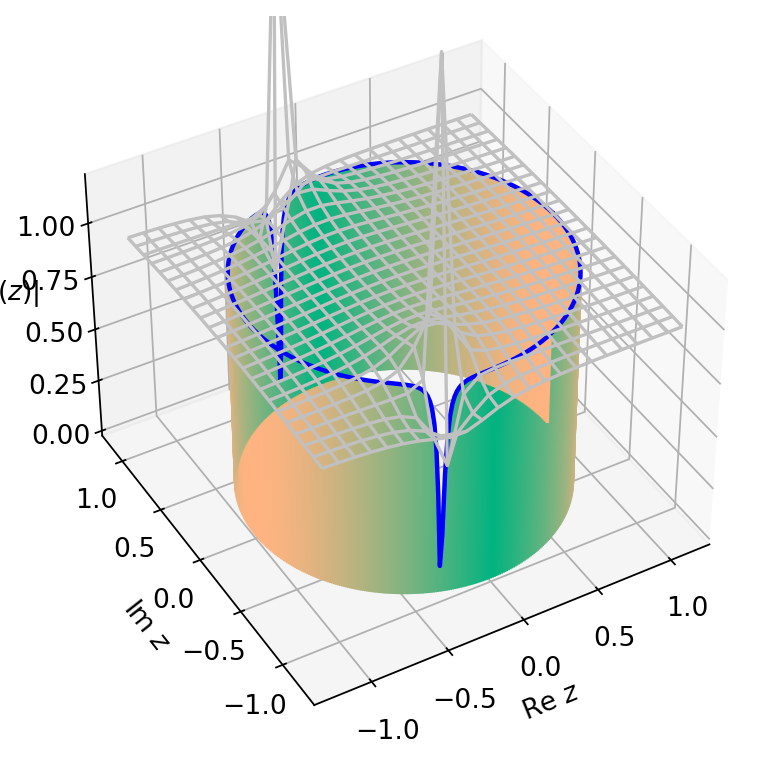

In [960]:
abs_H_plot()

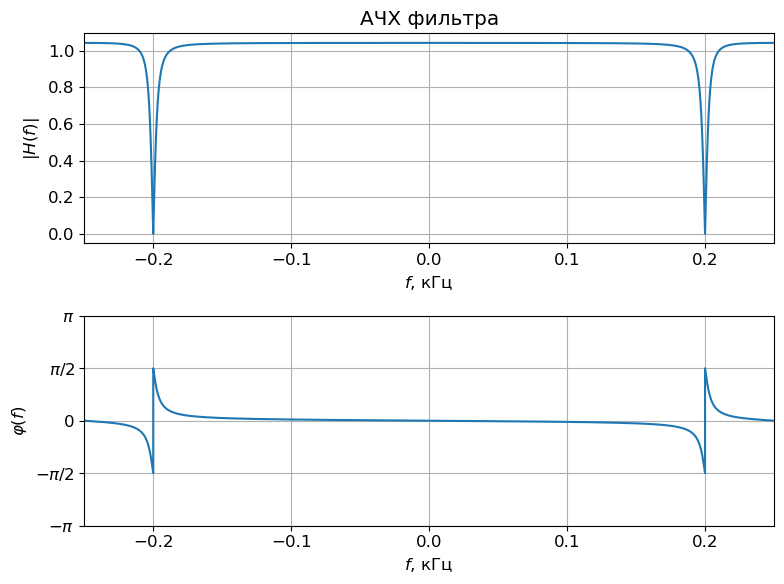

In [961]:
def freqresp_plot(f_scale='f', whole=True):
#         АЧХ фильтра
        system_dlti=signal.dlti([-(0.809017 + 0.587785 * 1j), -(0.809017 - 0.587785 * 1j)],
         [-(0.776473 + 0.562705j), -(0.776473 - 0.562705j)], 1, dt=1.0/fd)
        w, H = system_dlti.freqresp(w=None, n=2**18, whole=whole)
        if whole:
            w, H = w-np.pi, np.fft.fftshift(H)
        figure1 = plt.figure(figsize=[8, 6])
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)

        for ax in [ax1, ax2]:
            if f_scale=='f':
                f = fd*(w/(2*np.pi))/1e3
                ax.set_xlabel("$f$, кГц")
            elif f_scale=='\\nu':
                f = w/(2*np.pi)
                ax.set_xlabel("$%s$" % f_scale)
            elif f_scale=='\\theta':
                f = w
                ax.set_xlabel("$%s$, рад" % f_scale)
            ax.set_xlim([f[0], f[-1]])
            ax.grid()

        ax1.set_title("AЧХ фильтра")
        ax1.plot(f, abs(H))
        ax1.set_ylabel("$|H(%s)|$" % f_scale)


        ax2.plot(f, np.angle(H))
        ax2.set_ylabel("$\\varphi(%s)$" % f_scale)
        ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=("$-\\pi$", "$-\\pi/2$", "$0$", "$\\pi/2$", "$\\pi$"))
        plt.tight_layout()


freqresp_plot()

## Модуль 2. Метод билинейного *z*-преобразования

### Задача 2.1 Синтез фильтра нижних частот (ФНЧ)

| Варианты: |   1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |    10 | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $f_д$, Гц  | 6000 | 6200 | 6400 |  6600 | 6800 | 7000 | 6200 | 6400 |  6600 | 6800 |
|  $f_1$, Гц | 800 | 860 | 920 | 980 | 1040 | 1100 | 860 | 920 | 980 | 1040 |
|  $f_2$, Гц | 1100 | 1170 | 1240 | 1310 | 1380 | 1450 |1170 | 1240 | 1310 | 1380 |
|  $a_\max$, дБ | 0.4455 | 0.4455 | 0.4455 | 0.4455 | 0.4455 | 0.4455 |0.4455 | 0.4455 | 0.4455 | 0.4455 |
|  $a_\min$, дБ | 40 | 40 | 40 | 40 | 40 | 40 |40 | 40 | 40 | 40 |

 Получить коэффициенты разностного уравнения БИХ-фильтра нижних частот со следующими характеристиками:
* частота дискретизации $f_{д}$, 
* граничная частота полосы пропускания $f_1$,
* граничная частота полосы задерживания $f_2$,
* максимальное допустимое затухание в полосе пропускания $a_\max$,
* минимальное допустимое затухание в полосе задерживания $a_\min$.

Воспользоваться методом билинейного z-преобразования для фильтров: 

1) Баттервота,

2) Чебышёва 1 рода,

3) Чебышёва 2 рода,

4) Золотарёва—Кауэра.

Из четырех получившихся результатов выбрать фильтр, обладающий наименьшим порядком $N$ и построить схему его реализации в виде каскада биквадратных блоков. Для биквадратных блоков выбрать прямую каноническую реализацию. 


In [962]:
fd = 7000
f1 = 1100
f2 = 1450
a_max = 0.4455
a_min = 40

In [963]:
gpass=a_max
gstop=a_min
wp, ws = f1, f2

In [964]:
def mag_resp_plot(alpha, beta, dB=False):
    plt.figure(figsize=[10, 3], dpi=100)
    f_Nyquist=fd/2
    f, H = signal.freqz(beta, alpha, worN=np.linspace(-fd/2, fd/2, 1024**2), fs=fd)
    if dB:
        plt.plot(f, 20*np.log10(abs(H)))
        plt.ylabel("дБ")
        plt.plot([-f_Nyquist,-ws], [-gstop, -gstop], '--r')
        plt.plot([f_Nyquist,ws], [-gstop, -gstop], '--r')
        plt.plot([-wp,wp], [-gpass, -gpass], '--r')
        plt.ylim([-gstop*2, 5])
    else:
        plt.plot(f, abs(H))
        plt.ylabel("$|H(f)|$")

    plt.xlim([-fd/2, fd/2])
    plt.xticks([-fd/2, -Wn, 0, wp, ws, fd/2])
    plt.xlabel("$f$, Гц")
    plt.grid()
    plt.tight_layout()

In [965]:
# Пределы в линейном масштабе
delta_pass = 1- 10**(-gpass/20)
delta_stop = 10**(-gstop/20)
delta_pass, delta_stop

(0.04999694912604835, 0.01)

Порядок фильтра  17
Частота среза 1161.94 Гц
beta =  [1.96745911e-07 3.34468049e-06 2.67574439e-05 1.33787219e-04
 4.68255268e-04 1.21746370e-03 2.43492739e-03 3.82631448e-03
 4.78289310e-03 4.78289310e-03 3.82631448e-03 2.43492739e-03
 1.21746370e-03 4.68255268e-04 1.33787219e-04 2.67574439e-05
 3.34468049e-06 1.96745911e-07] alpha =  [ 1.00000000e+00 -5.70594855e+00  1.71218905e+01 -3.45501693e+01
  5.17135502e+01 -6.03048702e+01  5.63418245e+01 -4.28524093e+01
  2.67538886e+01 -1.37446201e+01  5.79508734e+00 -1.98942374e+00
  5.48229823e-01 -1.18535869e-01  1.93919085e-02 -2.25904554e-03
  1.67133678e-04 -5.90702521e-06]


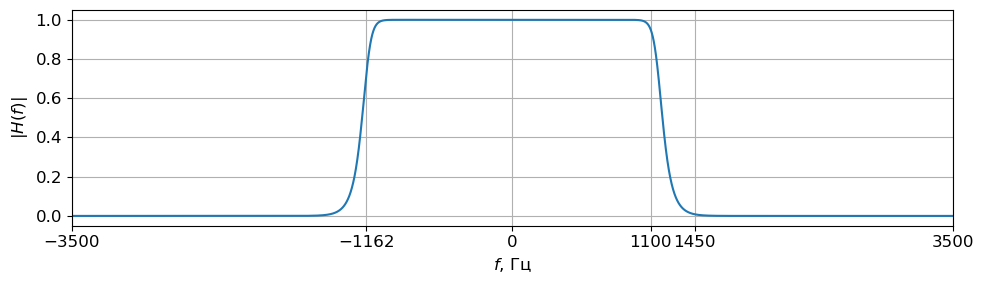

In [966]:
#СИНТЕЗ ФИЛЬТРА БАТТЕРВОРТА
N, Wn = signal.buttord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fd)
beta, alpha = signal.butter(N, Wn=Wn, btype='lowpass', analog=False, output='ba', fs=fd)
print("Порядок фильтра ", N)
print("Частота среза %.2f Гц" % Wn)
print('beta = ',beta, 'alpha = ',alpha)
mag_resp_plot(alpha, beta, dB=False)

Порядок фильтра  8
Частота среза 1390.96 Гц
beta =  [0.03649518 0.04932439 0.11218386 0.13359569 0.15683635 0.13359569
 0.11218386 0.04932439 0.03649518] alpha =  [ 1.         -1.75811262  2.5220812  -1.84955321  1.17531735 -0.38900849
  0.12780845 -0.01102103  0.00252295]


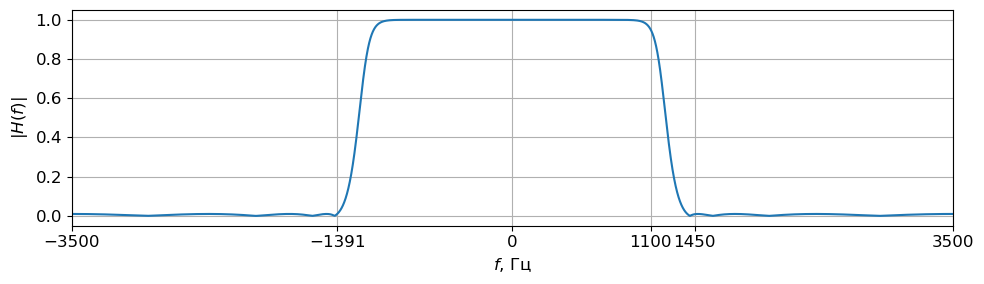

In [967]:
#СИНТЕЗ ФИkЬТРА ЧЕБЫШЕВА 1 РОДА
N, Wn = signal.cheb2ord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fd)
beta, alpha= signal.cheby2(N=N, rs=gstop, Wn=Wn, btype='low', analog=False, output='ba', fs=fd)
print("Порядок фильтра ", N)
print("Частота среза %.2f Гц" % Wn)
print('beta = ',beta, 'alpha = ',alpha)
mag_resp_plot(alpha, beta, dB=False)

Порядок фильтра  5
Частота среза 1100.00 Гц
beta =  [0.03293328 0.01281833 0.04480283 0.04480283 0.01281833 0.03293328] alpha =  [ 1.         -2.69322123  3.82538949 -3.08965326  1.44694614 -0.30835225]


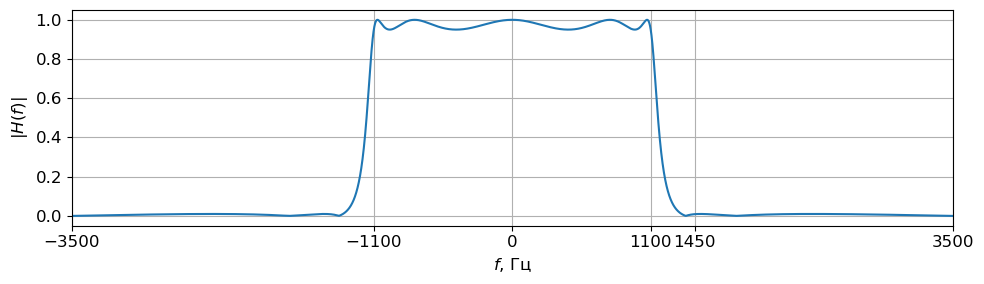

In [968]:
#СИНТЕЗ ФИЛЬТРА ЗОЛОТАРЕВА-КАУЭРА
N, Wn = signal.ellipord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fd)
beta, alpha = signal.ellip(N=N, rp=gpass, rs=gstop, Wn=Wn, btype='low', analog=False, output='ba', fs=fd)
print("Порядок фильтра ", N)
print("Частота среза %.2f Гц" % Wn)
print('beta = ',beta, 'alpha = ',alpha)
mag_resp_plot(alpha, beta, dB=False)

In [969]:
signal.tf2sos(beta, alpha)

array([[ 0.03293328,  0.03293328,  0.        ,  1.        , -0.58662722,
         0.        ],
       [ 1.        ,  0.0439985 ,  1.        ,  1.        , -1.08715379,
         0.58920377],
       [ 1.        , -0.6547773 ,  1.        ,  1.        , -1.01944022,
         0.89211204]])

### Задача 2.2 Синтез аналога двухкаскадного RC-фильтра (I способ)

Построить БИХ фильтр, эквивалентный двум последовательно соединенным RC-цепочкам интегрирующего типа (соединённым через развязывающий усилитель), воспользовавшись методом билинейного *z*-преобразования.

Параметры $RC$ и $\Delta t $ выбрать самостоятельно. 
Сравнить частотные и импульсные характеристики  цифровых фильтров и их аналоговых прототипов. 

In [970]:
RC = 0.005
dt = RC / 10

alpha = 2 * RC/dt

In [971]:
def H(z):
 return (1 + 2 * z**(-1) + z**(-2))/((alpha + 1)**2 + 2 * (1 - alpha**2) * z**(-1) + (alpha - 1)**2 * z**(-2))

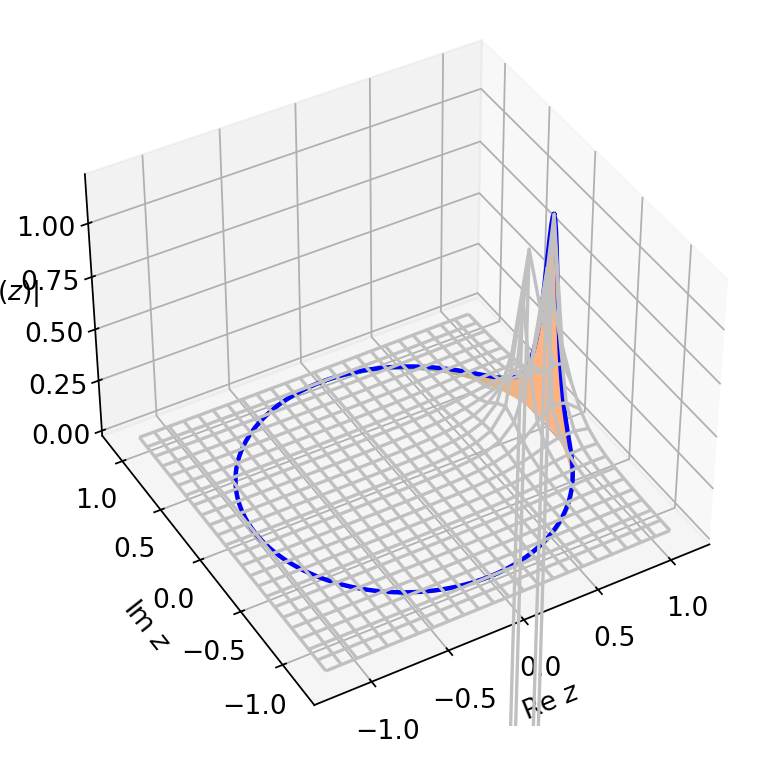

In [972]:
abs_H_plot()

In [973]:
def roots(a, b, c):
  D = b**2 - 4 * a * c + 0j
  if a == 0:
    return [-c / b, -c / b]
  return [(-b + D**(0.5))/(2 * a), (-b - D**(0.5))/(2 * a)]

In [974]:
w_a, H_a = signal.freqresp(signal.lti([1], [RC**2, 2*RC, 1]), w=np.linspace(-3*np.pi, 3*np.pi, 1000)/dt)
theta_d, H_d = signal.dfreqresp(signal.dlti([1, 2, 1], [(alpha + 1)**2, 2 * (1 - alpha**2), (alpha - 1)**2], dt=dt), w=np.linspace(-3*np.pi, 3*np.pi, 1000))

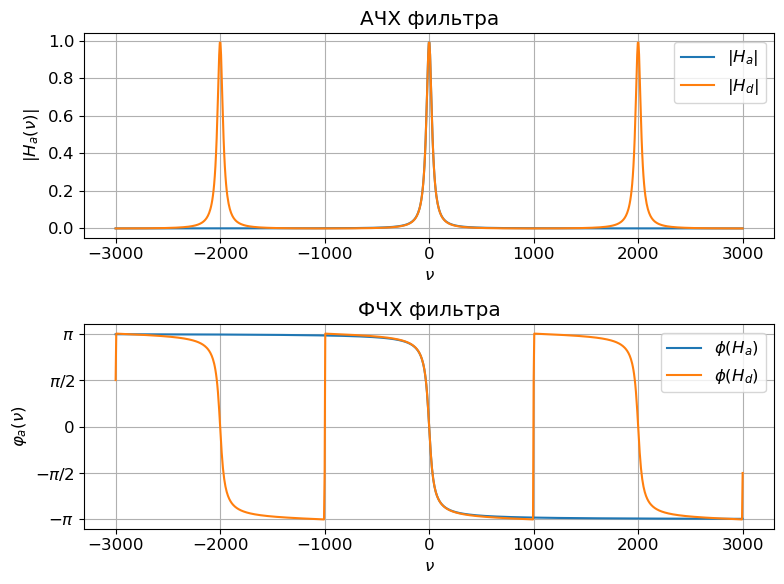

In [975]:
def freqresp_plot(H_a, H_d, w_a, theta_d, f_scale='f', whole=True):
#         АЧХ фильтра
        system_dlti=signal.dlti(roots(1, 2, 1), roots((alpha - 1)**2, 2 * (1 - alpha**2), (alpha + 1)**2), 1, dt=dt)
        w, H = system_dlti.freqresp(w=None, n=2**18, whole=whole)
        if whole:
            w, H = w-np.pi, np.fft.fftshift(H)
        figure1 = plt.figure(figsize=[8, 6])
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)

        for ax in [ax1, ax2]:
            if f_scale=='f':
                f = fd*(w/(2*np.pi))/1e3
                ax.set_xlabel("$f$, кГц")
            elif f_scale=='\\nu':
                f = w/(2*np.pi)
                ax.set_xlabel("$%s$" % f_scale)
            elif f_scale=='\\theta':
                f = w
                ax.set_xlabel("$%s$, рад" % f_scale)
            #ax.set_xlim([f[0], f[-1]])
            ax.grid()

        ax1.set_title("AЧХ фильтра")
        ax1.plot(w_a/(2*np.pi), abs(H_a), label=r'$|H_a|$')
        ax1.plot(theta_d/(2*np.pi*dt), abs(H_d), label=r'$|H_d|$')
        ax1.set_ylabel("$|H_a(%s)|$" % f_scale)
        ax1.legend()


        ax2.set_title("ФЧХ фильтра")
        ax2.plot(w_a/(2*np.pi), np.angle(H_a), label=r'$\phi(H_a)$')
        ax2.plot(theta_d/(2*np.pi*dt), np.angle(H_d), label=r'$\phi(H_d)$')
        ax2.set_ylabel("$\\varphi_a(%s)$" % f_scale)
        ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=("$-\\pi$", "$-\\pi/2$", "$0$", "$\\pi/2$", "$\\pi$"))
        ax2.legend()
        plt.tight_layout()



freqresp_plot(H_a, H_d, w_a, theta_d, '\\nu')

In [976]:
alpha_band=np.array([(alpha + 1)**2, 2 * (1 - alpha**2), (alpha - 1)**2])
beta_band=np.array([1, 2, 1])
N=60
x=np.zeros(N) #eдиничный сигнал
x[0]=1
h=signal.lfilter(b=beta_band, a=alpha_band, x=x) #реакция на единичный сигнал -- импульсная характеристика
h

array([0.00226757, 0.00863838, 0.0160427 , 0.02195832, 0.02660165,
       0.03016136, 0.03280175, 0.03466563, 0.03587697, 0.03654315,
       0.03675702, 0.0365987 , 0.03613714, 0.03543153, 0.03453255,
       0.03348343, 0.03232092, 0.03107614, 0.0297753 , 0.02844037,
       0.02708964, 0.02573823, 0.02439852, 0.02308054, 0.0217923 ,
       0.02054009, 0.01932874, 0.01816181, 0.01704184, 0.01597047,
       0.01494859, 0.0139765 , 0.01305398, 0.0121804 , 0.01135482,
       0.01057602, 0.00984256, 0.00915288, 0.0085053 , 0.00789804,
       0.00732931, 0.00679727, 0.00630009, 0.00583596, 0.00540309,
       0.00499974, 0.00462421, 0.00427486, 0.00395011, 0.00364845,
       0.00336841, 0.00310862, 0.00286777, 0.00264459, 0.00243791,
       0.00224662, 0.00206964, 0.001906  , 0.00175476, 0.00161504])

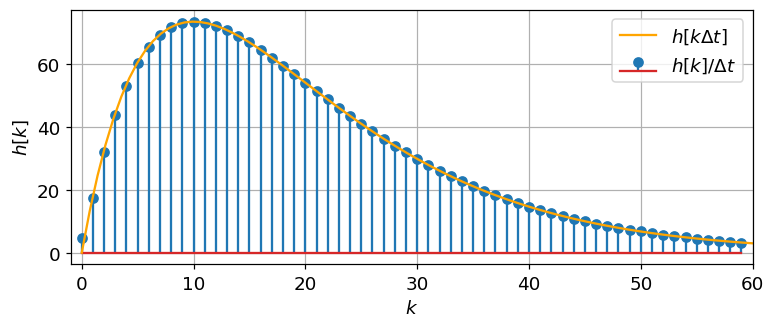

In [977]:
t, h_a = signal.impulse(signal.lti([1], [RC**2, 2*RC, 1]))
k=np.arange(N)
plt.figure(figsize=[8, 3], dpi=110)
plt.stem(k, h / dt, label=r'$h[k]/\Delta t$')
plt.plot(t / dt, h_a, label=r'$h[k\Delta t]$', color='orange')
plt.xlabel("$k$")
plt.xlim(-1, 60)
plt.ylabel("$h[k]$")
plt.legend()
plt.grid()
plt.show()

## Модуль 3. Метод инвариантной импульсной характеристики.

### Задача 3.1 Синтез аналога двухкаскадного RC-фильтра (II способ)

Построить БИХ фильтр, эквивалентный двум последовательно соединенным RC-цепочкам интегрирующего типа (соединённым через развязывающий усилитель), воспользовавшись методом инвариантной импульсной характеристики.

Параметры $RC$ и $\Delta t $ выбрать самостоятельно. 
Сравнить частотные и импульсные характеристики  цифровых фильтров и их аналоговых прототипов. 

In [978]:
RC = 0.005
dt = RC / 10

alpha = dt/RC

In [979]:
def H(z):
 return (alpha**2 * np.exp(-alpha) * z**(-1))/(1 - 2 * np.exp(-alpha) * z**(-1) + np.exp(-2 * alpha) * z**(-2))

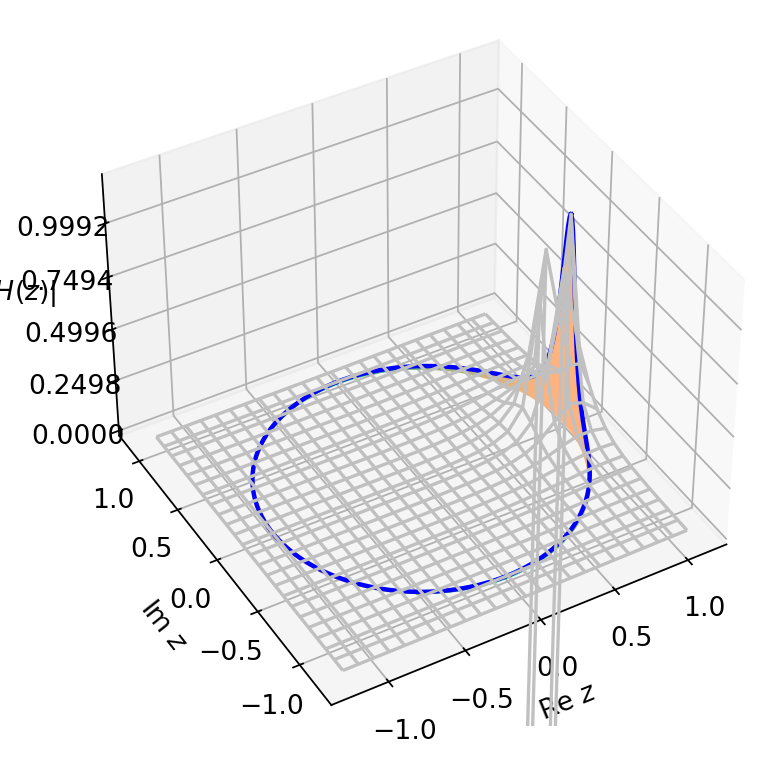

In [980]:
abs_H_plot()

In [981]:
print("Analog numerator:", [1])
print("Analog denominator:", [RC**2, 2*RC, 1])
print("Digital numerator:", [0, alpha**2 * np.exp(-alpha), 0])
print("Digital denominator:", [1, -2 * np.exp(-alpha), np.exp(-2 * alpha)])

print("Numerator (digital):", [alpha**2 * np.exp(-alpha)])
print("Denominator (digital):", [1, -2 * np.exp(-alpha), np.exp(-2 * alpha)])

Analog numerator: [1]
Analog denominator: [2.5e-05, 0.01, 1]
Digital numerator: [0, 0.009048374180359597, 0]
Digital denominator: [1, -1.809674836071919, 0.8187307530779818]
Numerator (digital): [0.009048374180359597]
Denominator (digital): [1, -1.809674836071919, 0.8187307530779818]


In [982]:
w_a, H_a = signal.freqresp(signal.lti([1], [RC**2, 2*RC, 1]), w=np.linspace(-3*np.pi, 3*np.pi, 1000)/dt)
theta_d, H_d = signal.dfreqresp(signal.dlti([0,alpha**2 * np.exp(-alpha),0], [1, -2 * np.exp(-alpha), np.exp(-2 * alpha)], dt=dt), w=np.linspace(-3*np.pi, 3*np.pi, 1000))

d:\Anaconda3\Lib\site-packages\scipy\signal\_ltisys.py:600: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


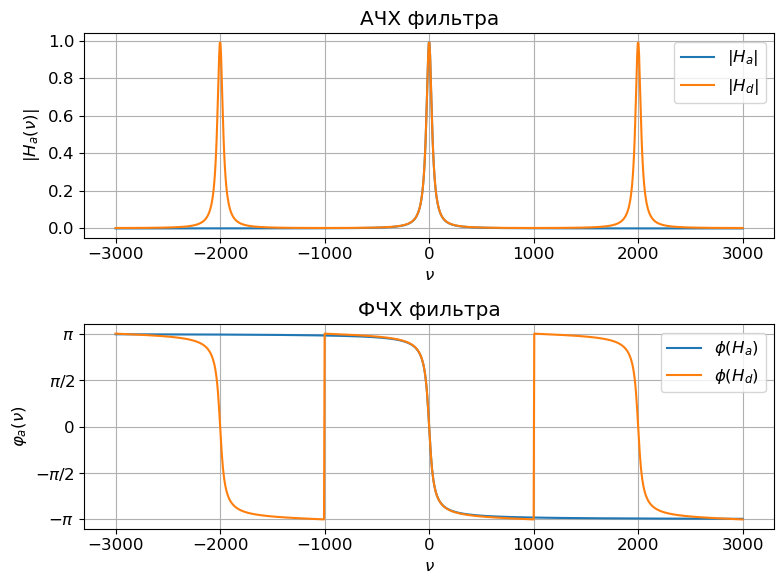

In [983]:
def freqresp_plot(H_a, H_d, w_a, theta_d, f_scale='f', whole=True):
#         АЧХ фильтра
        system_dlti=signal.dlti(roots(0, alpha**2 * np.exp(-alpha), 0), roots(np.exp(-2 * alpha), -2 * np.exp(-alpha), 1), 1, dt=dt)
        w, H = system_dlti.freqresp(w=None, n=2**18, whole=whole)
        if whole:
            w, H = w-np.pi, np.fft.fftshift(H)
        figure1 = plt.figure(figsize=[8, 6])
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)

        for ax in [ax1, ax2]:
            if f_scale=='f':
                f = fd*(w/(2*np.pi))/1e3
                ax.set_xlabel("$f$, кГц")
            elif f_scale=='\\nu':
                f = w/(2*np.pi)
                ax.set_xlabel("$%s$" % f_scale)
            elif f_scale=='\\theta':
                f = w
                ax.set_xlabel("$%s$, рад" % f_scale)
            #ax.set_xlim([f[0], f[-1]])
            ax.grid()

        ax1.set_title("AЧХ фильтра")
        ax1.plot(w_a/(2*np.pi), abs(H_a), label=r'$|H_a|$')
        ax1.plot(theta_d/(2*np.pi*dt), abs(H_d), label=r'$|H_d|$')
        ax1.set_ylabel("$|H_a(%s)|$" % f_scale)
        ax1.legend()


        ax2.set_title("ФЧХ фильтра")
        ax2.plot(w_a/(2*np.pi), np.angle(H_a), label=r'$\phi(H_a)$')
        ax2.plot(theta_d/(2*np.pi*dt), np.angle(H_d), label=r'$\phi(H_d)$')
        ax2.set_ylabel("$\\varphi_a(%s)$" % f_scale)
        ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=("$-\\pi$", "$-\\pi/2$", "$0$", "$\\pi/2$", "$\\pi$"))
        ax2.legend()
        plt.tight_layout()



freqresp_plot(H_a, H_d, w_a, theta_d, '\\nu')

In [984]:
alpha_band=np.array([1, -2 * np.exp(-alpha), np.exp(-2 * alpha)])
beta_band=np.array([0, alpha**2 * np.exp(-alpha), 0])
N=60
x=np.zeros(N) #eдиничный сигнал
x[0]=1
h=signal.lfilter(b=beta_band, a=alpha_band, x=x) #реакция на единичный сигнал -- импульсная характеристика
h

array([0.        , 0.00904837, 0.01637462, 0.02222455, 0.0268128 ,
       0.03032653, 0.0329287 , 0.03476097, 0.03594632, 0.03659127,
       0.03678794, 0.03661582, 0.03614331, 0.03542913, 0.03452357,
       0.03346952, 0.03230344, 0.0310562 , 0.0297538 , 0.02841804,
       0.02706706, 0.02571585, 0.02437669, 0.02305953, 0.02177231,
       0.02052125, 0.01931113, 0.01814549, 0.01702682, 0.01595673,
       0.01493612, 0.01396525, 0.01304391, 0.01217145, 0.01134691,
       0.01056908, 0.00983654, 0.0091477 , 0.00850089, 0.00789435,
       0.00732626, 0.0067948 , 0.00629814, 0.00583448, 0.00540203,
       0.00499905, 0.00462384, 0.00427478, 0.00395028, 0.00364883,
       0.00336897, 0.00310934, 0.00286861, 0.00264554, 0.00243895,
       0.00224772, 0.0020708 , 0.0019072 , 0.00175598, 0.00161627])

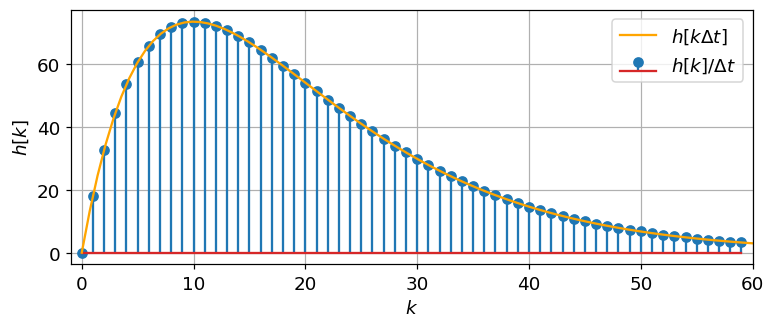

In [985]:
t, h_a = signal.impulse(signal.lti([1], [RC**2, 2*RC, 1]))
k=np.arange(N)
plt.figure(figsize=[8, 3], dpi=110)
plt.stem(k, h / dt, label=r'$h[k]/\Delta t$')
plt.plot(t / dt, h_a, label=r'$h[k\Delta t]$', color='orange')
plt.xlabel("$k$")
plt.xlim(-1, 60)
plt.ylabel("$h[k]$")
plt.legend()
plt.grid()
plt.show()


### Задача 3.2 Цифровая фильтрация реальных сигналов (творческая задача)

Творческая задача выполняется в одном из двух вариантов: вариант А (фильтрация сигнала из .wav файла) и вариант Б (фильтрация реального сигнала с цифрового осциллографа). Выбор варианта остается за студентом. *Плагиат при выполнении творческой задачи недопустим.*

#### Вариант А (фильтрация сигнала из .wav файла).
 
Выполнить фильтрацию `.wav` файла с помощью одного из цифровых фильтров, рассмотренных в первой и второй лабораторной работах. Проиллюстрировать, как в результате фильтрации изменился сигнал. Привести пример, для чего выбранный фильтр может быть применен. 

Для этой задачи `.wav` файл можно загрузить, например, с сайта [freesound.org](https://freesound.org/) или взять из предыдущих лабораторных работ.

*При выполнении творческой задачи в виде фильтрации звука из wav-файла необходимо составить аннотацию своей работы (5-6 предложений)*. Аннотацию необходимо поместить в свой ipynb файл и в таблицу https://disk.yandex.ru/i/Jo1Mx87rDMqGGQ .

#### Вариант Б (фильтрация реального сигнала с цифрового осциллографа).

В данном варианте задача выполняется на компьютерах в аудитории с использованием учебного цифрового осциллографа PV6501 (https://www.pv65.ru/6501/index.html). При выполнении творческой задачи по варианту Б составлять аннотацию не требуется.
Последовательность действий следующая. 
* Загрузить компьютер в аудитории под Windows 7.
* Запустить на нем управляющую программу цифрового осциллографа PV6501.
* Получить на время занятия два цифровых осциллографа PV6501 (обычно задание выполняется в парах по 2 студента).
* Выполнить калибровку уровня нуля на цифровом осциллографе. 
* Подключить генераторы осциллографов к схеме резисторного сумматора (плата выдается преподавателем). К выходу схемы подключить один из осциллографов. 
* Подать на входы схемы низкочастотные синусоиды, например, 5 и 10 кГц. Пронаблюдать сигнал суммы двух синусоид. 
* Записать осциллограмму в txt файл для дальнейшей обработки на python.
* Выполить анализ сигнала.
* Выполнить фильтрацию сигнала на python. 
* Проанализировать сигнал после фильтрации. 

In [986]:
%matplotlib notebook
# Функции для анализа осциллограммы из файла.
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
def oscilloscope_file_read(file, const_level=0):
    f = open(file)
    str1 = f.read().split('\n')
    f.closed
    
    figsize=[8, 4]

    # dt
    val, unit = str1[1].replace(',', '.').split(' ')[3:5]
    val=float(val)
    if unit=='uS':
        val*=1e-6
    elif unit=='nS':
        val*=1e-9
    elif unit=='mS':
        val*=1e-3    
    fs = int(1.0 / val)
    
    #Voltage step 
    val, unit = str1[2].replace(',', '.').split(' ')[3:5]
    dv=float(val)
    if unit=='mV':
        dv*=1e-3  


    # Zero level
    zero_level= int(str1[3].split(' ')[3])
    str_num = len(str1)
    signal_lev = np.empty(shape=(str_num-8), dtype=float)
    for k, u in enumerate(range(7, str_num-1, 1)):
        data = str1[u].split()
        signal_lev[k]=(int(data[1])-zero_level)*dv-const_level
    return fs, signal_lev 

def analyse(fs, signal_lev, window='boxcar'):
    figsize=[16,4]
    plt.rcParams['font.size'] = '12'    
    window = signal.get_window(window, Nx=len(signal_lev), fftbins=True)
    signal_lev = signal_lev*window
    plt.figure(figsize=figsize)
    plt.plot(np.arange(signal_lev.size)/fs*1e3, signal_lev, '.-')
    plt.title("Сигнал")
    plt.xlabel("$t$, мc")
    plt.ylabel(r"$x(k\Delta t)w[k]$, В")
    plt.grid()
    plt.tight_layout()
    Xn = np.fft.fftshift(np.fft.fft(signal_lev, 2**18))
    f = fs*np.linspace(-0.5, 0.5, num=Xn.size, endpoint=False)
#     plt.show()

    plt.figure(figsize=figsize)
    plt.title("ДВПФ (модуль), линейный масштаб")
    plt.plot(f/1e3, abs(Xn))
    plt.grid()
    plt.xlabel("$f$, кГц")
    plt.ylabel("$|X(f)|$")
    plt.tight_layout()
#     plt.show()

    plt.figure(figsize=figsize)
    maxXn=max(abs(Xn))
    plt.title("ДВПФ (модуль), дБ")
    plt.plot(f/1e3, 20*np.log10(abs(Xn)/maxXn))
    plt.grid()
    plt.xlabel("$f$, кГц")
    plt.ylabel("АЧХ, дБ")
    plt.tight_layout()
#     plt.show()

In [987]:
%matplotlib inline

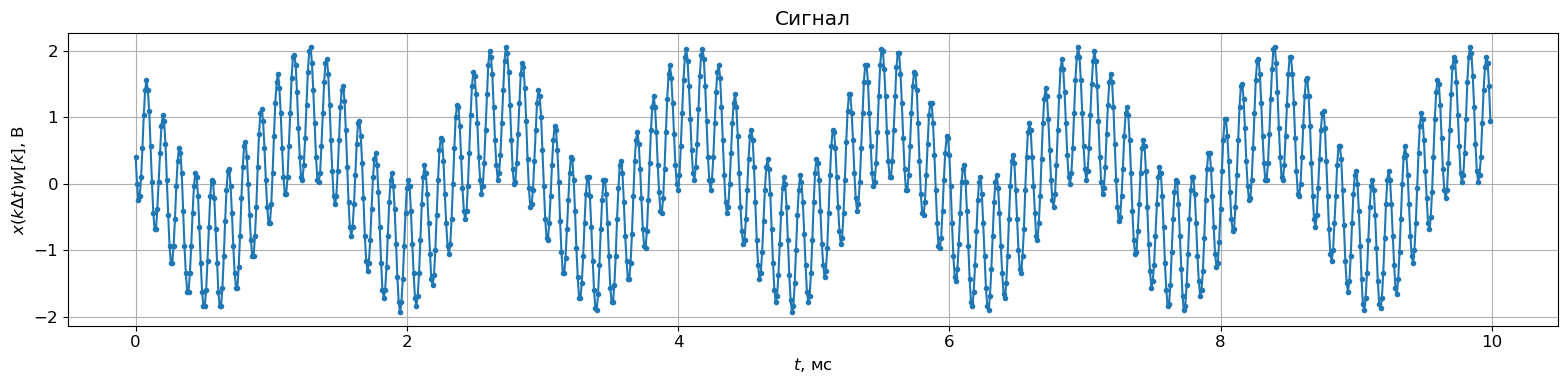

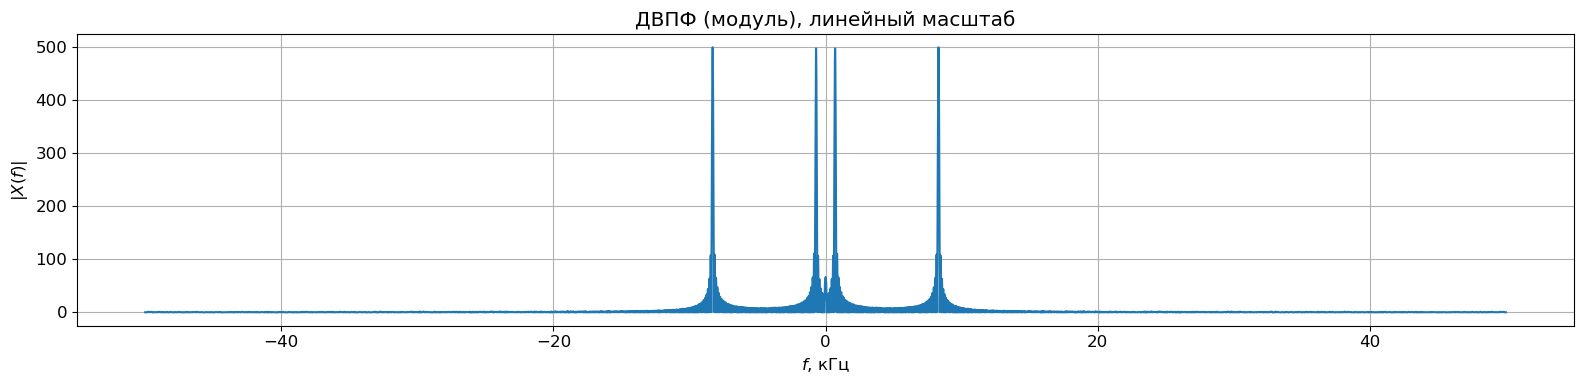

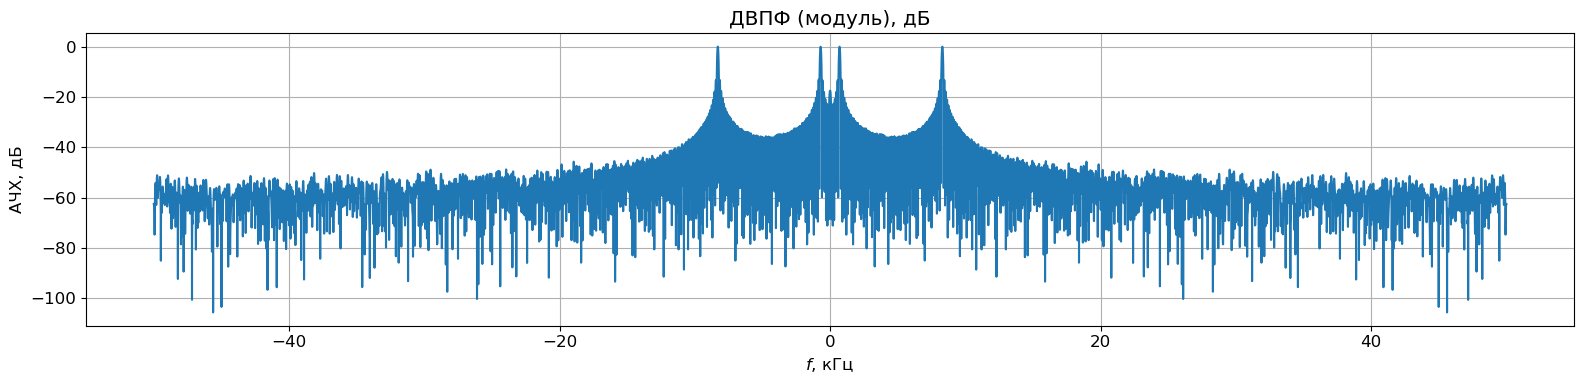

In [988]:
# Чтение сигнала из файла
fs, signal_lev = oscilloscope_file_read(file='oscila.txt', const_level=0)
# Анализ сигнала
analyse(fs, signal_lev, window='boxcar')

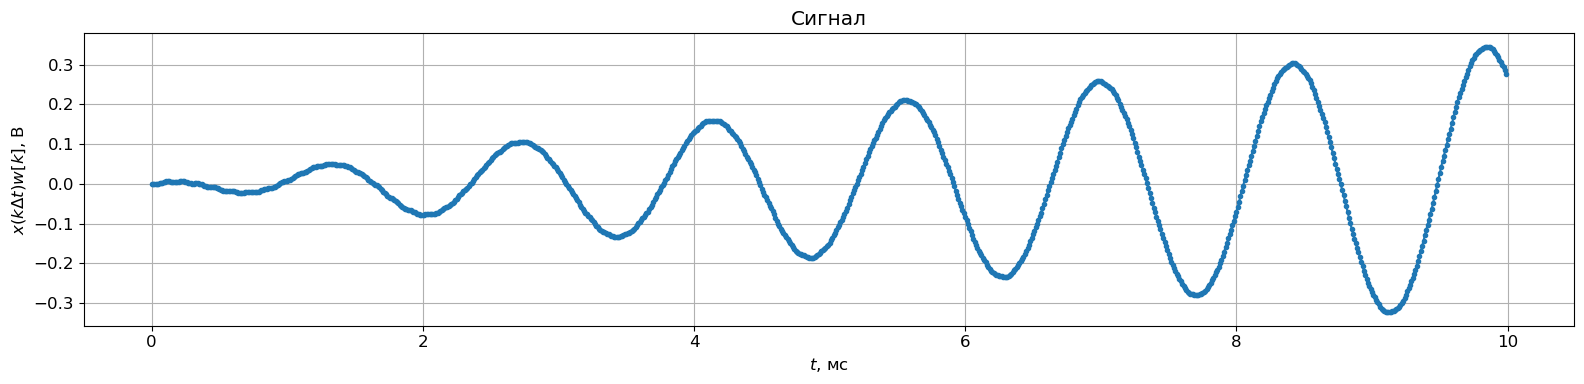

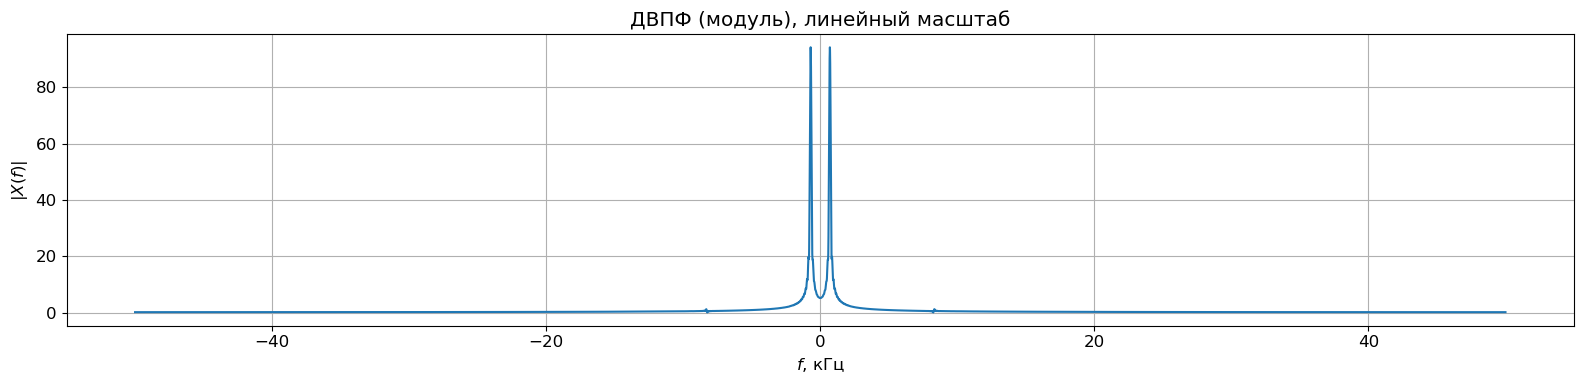

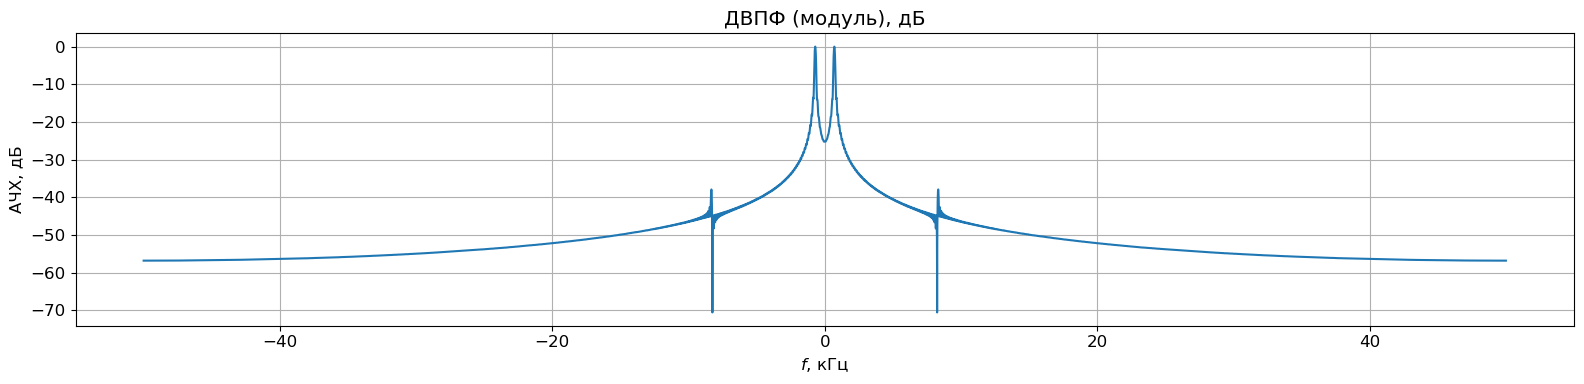

In [989]:
#Пример фильтрации сигнала
beta, alpha = signal.iirpeak(w0=700, Q=50,fs=fs)
y_out = signal.lfilter(beta, alpha, signal_lev)
analyse(fs, signal_lev=y_out, window='boxcar')

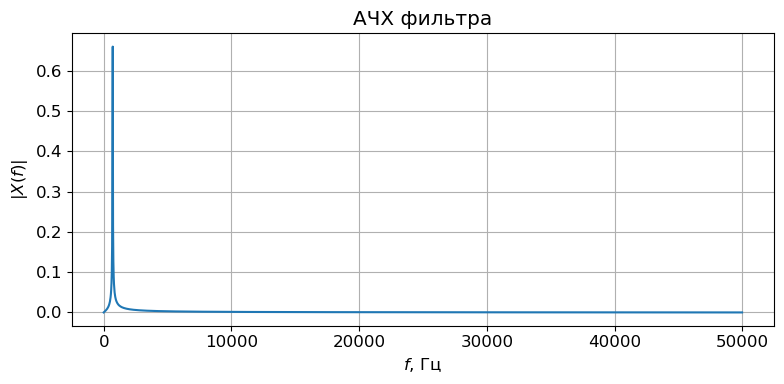

In [990]:
f, Xf = signal.freqz(beta, alpha, worN=2048, whole=False, plot=None, fs=fs, include_nyquist=False)
plt.figure(figsize=[8,4])
plt.plot(f, abs(Xf))
plt.title("АЧХ фильтра")
plt.xlabel("$f$, Гц")
plt.ylabel("$|X(f)|$")
plt.grid()
plt.tight_layout()
plt.show()

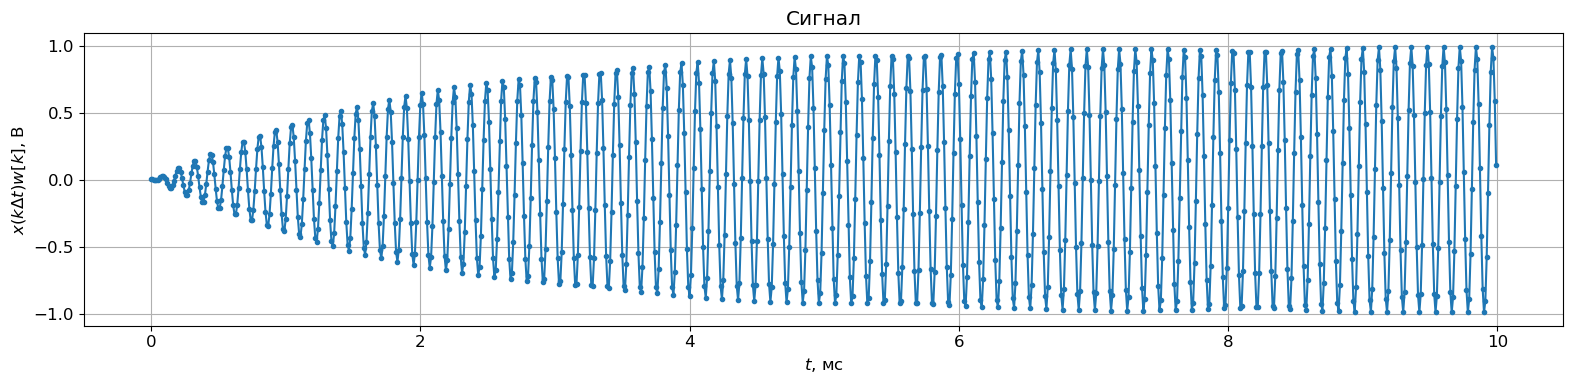

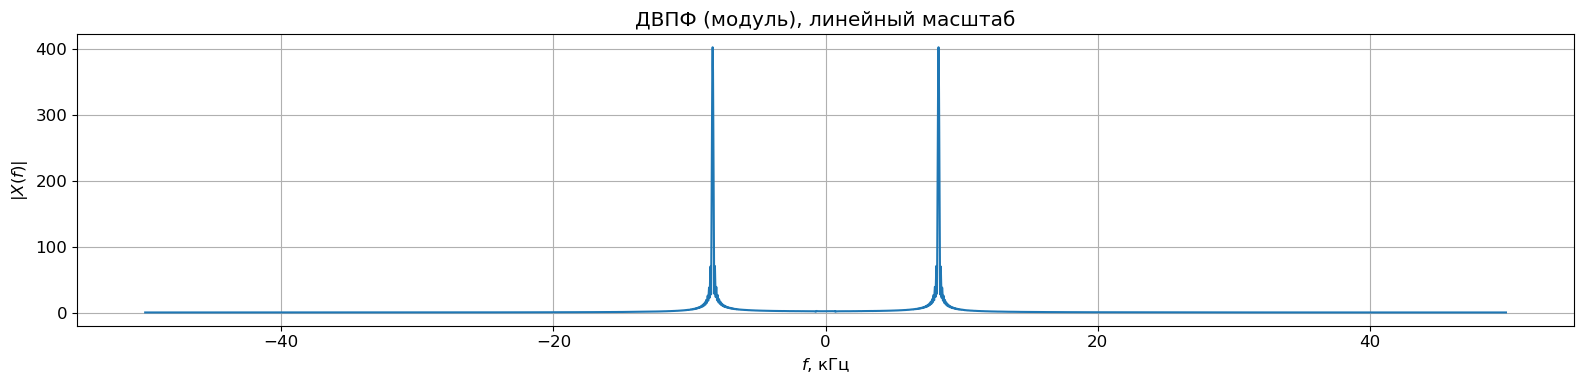

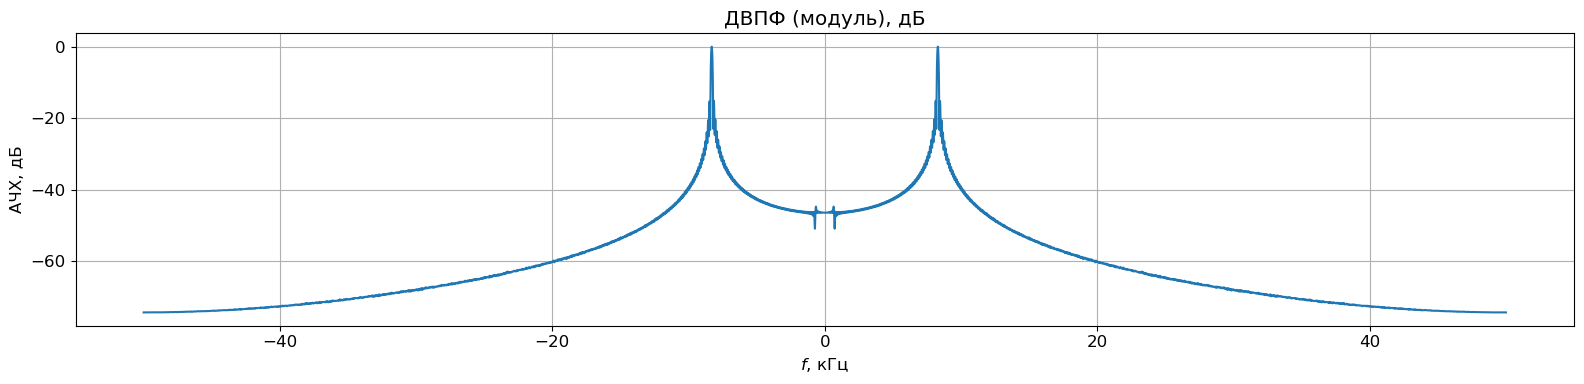

In [991]:
#Пример фильтрации сигнала
beta, alpha = signal.iirpeak(w0=8300, Q=50,fs=fs)
y_out = signal.lfilter(beta, alpha, signal_lev)
analyse(fs, signal_lev=y_out, window='boxcar')

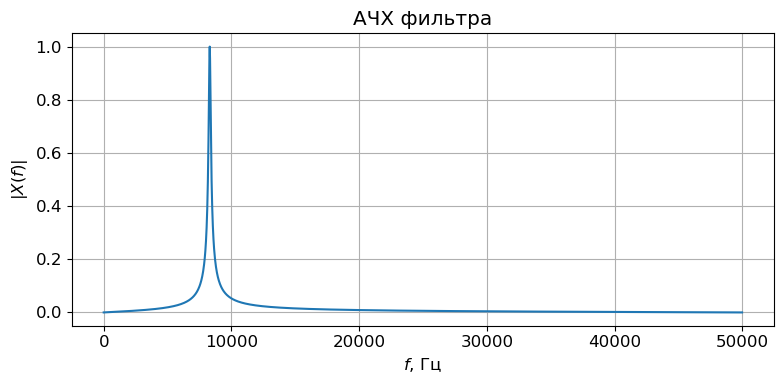

In [992]:
f, Xf = signal.freqz(beta, alpha, worN=2048, whole=False, plot=None, fs=fs, include_nyquist=False)
plt.figure(figsize=[8,4])
plt.plot(f, abs(Xf))
plt.title("АЧХ фильтра")
plt.xlabel("$f$, Гц")
plt.ylabel("$|X(f)|$")
plt.grid()
plt.tight_layout()
plt.show()